In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'squeezeNet_train_more/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('SqueezeNet Classifier. First Test. No global clipnorm.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0) - 0.5 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
                aug = self.except_transform(image=img)
                img = aug['image'] 
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

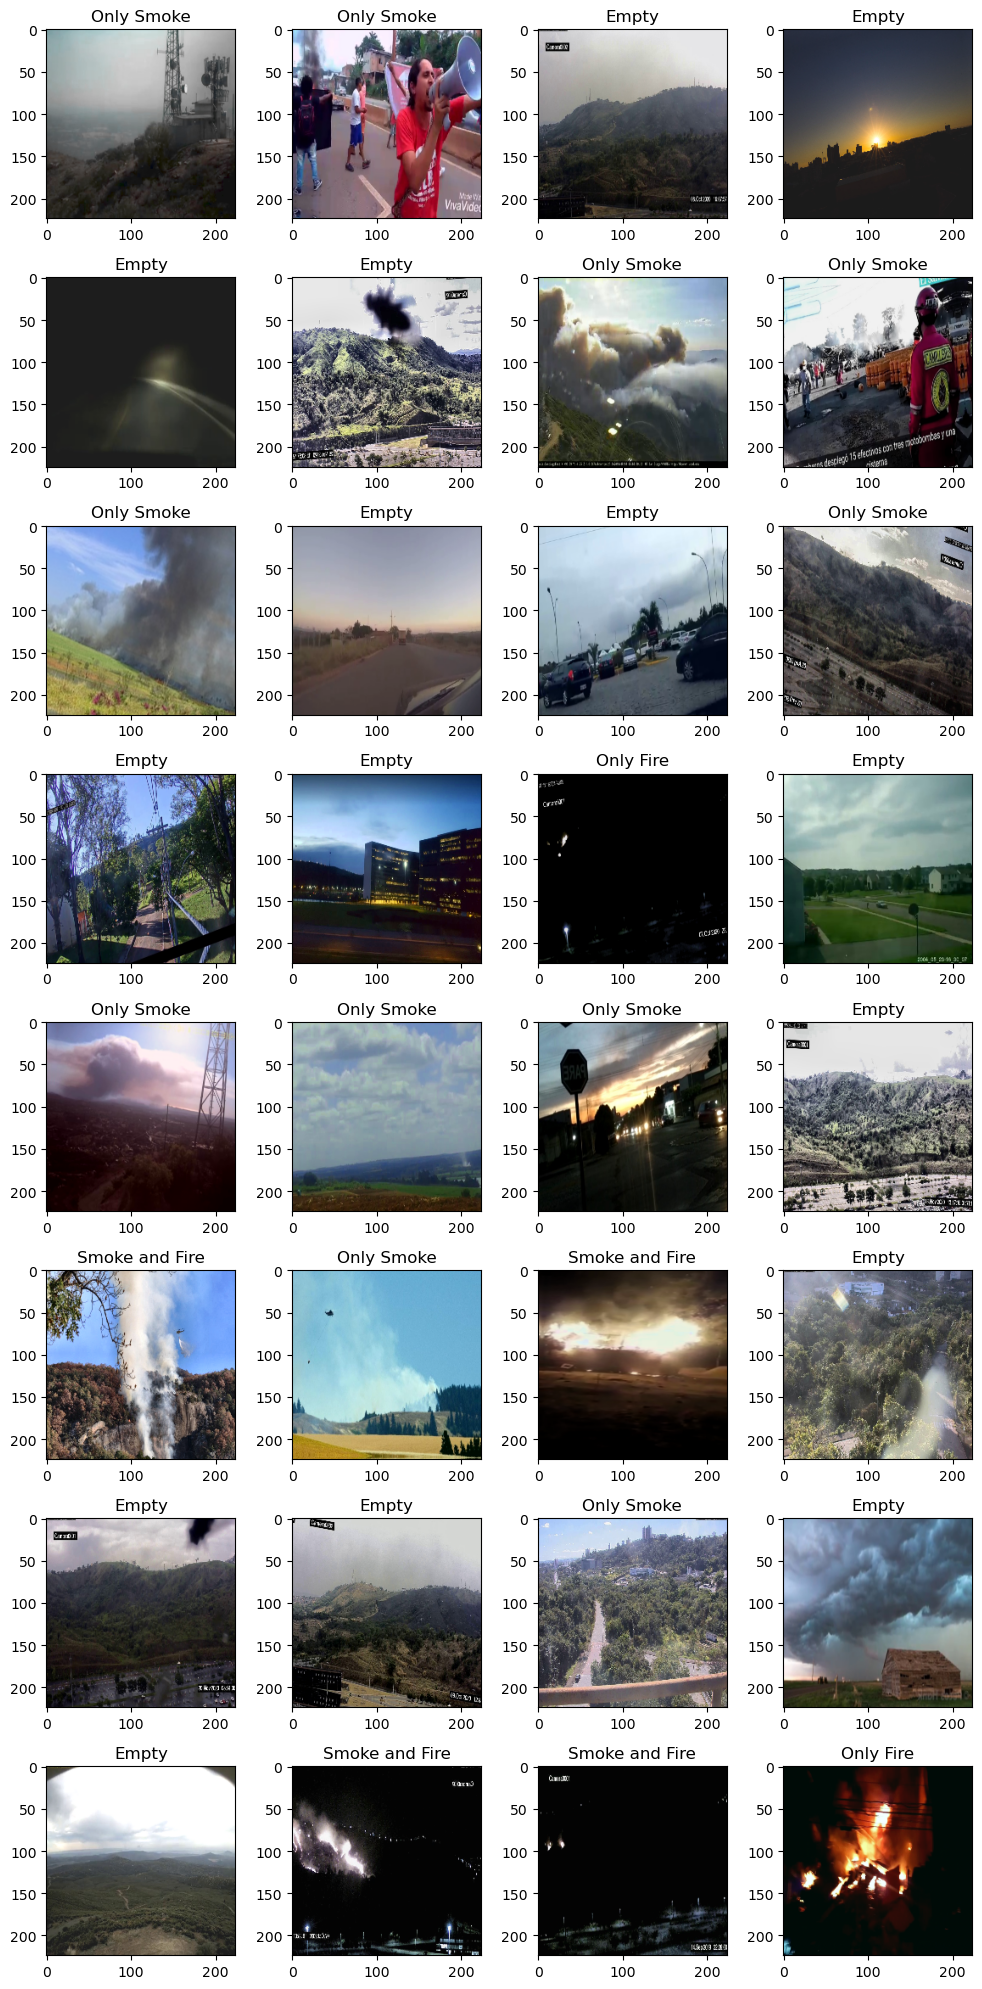

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: SqueezeNet

In [10]:
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU()
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU()
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class SqueezeNet(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.5) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
            # Final convolution
        )

        # Final convolution is initialized differently from the rest
        smoke_final_conv = nn.Conv2d(512, 1, kernel_size=1)
        fire_final_conv = nn.Conv2d(512, 1, kernel_size=1)
        self.smoke = nn.Sequential(
            nn.Dropout(p=dropout),
            smoke_final_conv,
            nn.ReLU(), 
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=1, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=dropout),
            fire_final_conv,
            nn.ReLU(), 
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=1, out_features=1)
        )

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         if m is smoke_final_conv:
        #             nn.init.normal_(m.weight, mean=0.0, std=0.01)
        #         elif m is fire_final_conv:
        #             nn.init.normal_(m.weight, mean=0.0, std=0.01)
        #         else:
        #             nn.init.kaiming_uniform_(m.weight)
        #         if m.bias is not None:
        #             nn.init.constant_(m.bias, 0)
        #     elif isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, 0, 0.01)
        #         nn.init.constant_(m.bias, 0)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        smoke = self.smoke(x)
        fire = self.fire(x)
        x = torch.cat((smoke, fire), dim=-1)
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

#MODEL = "BED"
MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 125 #100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    #LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"
    LOAD_MODEL_FILE = "squeezeNet/" + "SQUEEZE_best_classifier.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using Squeeze Classifier
Model shape is tensor([[-0.8682, -0.5742],
        [-0.8681, -0.5743],
        [-0.8682, -0.5742],
        [-0.8683, -0.5743]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU()
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU()
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU()
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU()
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU()
      (expand

/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



Trainable parameters = 723526
Total parameters = 723526



# Main Function

In [18]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        loss_fn = BCE_LOSS(device=DEVICE)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + MODEL + "_Temp_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_best_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + MODEL + '_last_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    squeeze_model = main()

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE

***Start Training: 21:24:41

Loading Model. Train from epoch: 74

=== EPOCH 74/124 ===
Learning Rate = 0.0005120000000000001



Training:   0%|                                                                                                                      | 0/269 [00:00<?, ?it/s]/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.295      |18.596      |6.699       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.482      |18.134      |7.347       

SMOKE -> Precision: 0.855 - Recall: 0.929 - Accuracy: 0.890 - F1: 0.890
FIRE -> Precision: 0.932 - Recall: 0.923 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 25.482

=== EPOCH 75/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.234      |18.547      |6.687       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.389      |17.883      |7.506       

SMOKE -> Precision: 0.883 - Recall: 0.886 - Accuracy: 0.889 - F1: 0.885
FIRE -> Precision: 0.904 - Recall: 0.937 - Accuracy: 0.958 - F1: 0.920

Saving model with new best validation loss: 25.389

=== EPOCH 76/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.921      |18.292      |6.629       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.967      |16.951      |8.015       

SMOKE -> Precision: 0.870 - Recall: 0.918 - Accuracy: 0.895 - F1: 0.894
FIRE -> Precision: 0.872 - Recall: 0.949 - Accuracy: 0.951 - F1: 0.909

Saving model with new best validation loss: 24.967

=== EPOCH 77/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.026      |17.588      |6.438       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.355      |18.081      |7.274       

SMOKE -> Precision: 0.906 - Recall: 0.861 - Accuracy: 0.890 - F1: 0.883
FIRE -> Precision: 0.947 - Recall: 0.896 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 78/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.775      |17.510      |6.265       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.121      |17.069      |7.052       

SMOKE -> Precision: 0.903 - Recall: 0.880 - Accuracy: 0.897 - F1: 0.891
FIRE -> Precision: 0.929 - Recall: 0.919 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 24.121

=== EPOCH 79/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.604      |17.327      |6.277       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.966      |17.484      |7.482       

SMOKE -> Precision: 0.889 - Recall: 0.888 - Accuracy: 0.893 - F1: 0.888
FIRE -> Precision: 0.896 - Recall: 0.936 - Accuracy: 0.955 - F1: 0.916

=== EPOCH 80/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.530      |17.284      |6.247       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.369      |16.945      |7.424       

SMOKE -> Precision: 0.900 - Recall: 0.887 - Accuracy: 0.898 - F1: 0.894
FIRE -> Precision: 0.942 - Recall: 0.898 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 81/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.343      |17.134      |6.208       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.372      |17.129      |7.243       

SMOKE -> Precision: 0.900 - Recall: 0.873 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.932 - Recall: 0.913 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 82/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.733      |16.651      |6.082       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.974      |16.833      |7.142       

SMOKE -> Precision: 0.900 - Recall: 0.883 - Accuracy: 0.897 - F1: 0.892
FIRE -> Precision: 0.938 - Recall: 0.917 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 23.974

=== EPOCH 83/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.600      |16.455      |6.145       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.258      |16.879      |7.379       

SMOKE -> Precision: 0.897 - Recall: 0.885 - Accuracy: 0.896 - F1: 0.891
FIRE -> Precision: 0.925 - Recall: 0.920 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 84/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.219      |16.185      |6.035       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.111      |16.280      |6.831       

SMOKE -> Precision: 0.884 - Recall: 0.917 - Accuracy: 0.902 - F1: 0.900
FIRE -> Precision: 0.940 - Recall: 0.918 - Accuracy: 0.964 - F1: 0.929

Saving model with new best validation loss: 23.111

=== EPOCH 85/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.328      |16.471      |5.857       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.967      |16.678      |7.288       

SMOKE -> Precision: 0.872 - Recall: 0.923 - Accuracy: 0.898 - F1: 0.897
FIRE -> Precision: 0.902 - Recall: 0.936 - Accuracy: 0.957 - F1: 0.919

=== EPOCH 86/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.973      |16.265      |5.708       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.491      |16.360      |7.131       

SMOKE -> Precision: 0.890 - Recall: 0.906 - Accuracy: 0.901 - F1: 0.898
FIRE -> Precision: 0.924 - Recall: 0.920 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 87/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.302      |16.452      |5.850       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.005      |16.009      |6.996       

SMOKE -> Precision: 0.901 - Recall: 0.893 - Accuracy: 0.901 - F1: 0.897
FIRE -> Precision: 0.920 - Recall: 0.933 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 23.005

=== EPOCH 88/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.899      |16.132      |5.767       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.053      |16.405      |7.647       

SMOKE -> Precision: 0.890 - Recall: 0.918 - Accuracy: 0.906 - F1: 0.904
FIRE -> Precision: 0.896 - Recall: 0.942 - Accuracy: 0.957 - F1: 0.918

=== EPOCH 89/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.510      |15.778      |5.732       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.777      |15.800      |6.977       

SMOKE -> Precision: 0.885 - Recall: 0.913 - Accuracy: 0.901 - F1: 0.899
FIRE -> Precision: 0.930 - Recall: 0.928 - Accuracy: 0.963 - F1: 0.929

Saving model with new best validation loss: 22.777

=== EPOCH 90/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.584      |15.859      |5.724       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.044      |16.098      |6.945       

SMOKE -> Precision: 0.899 - Recall: 0.902 - Accuracy: 0.904 - F1: 0.901
FIRE -> Precision: 0.924 - Recall: 0.926 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 91/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.323      |15.652      |5.671       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.226      |15.481      |6.745       

SMOKE -> Precision: 0.891 - Recall: 0.906 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.925 - Recall: 0.934 - Accuracy: 0.963 - F1: 0.930

Saving model with new best validation loss: 22.226

=== EPOCH 92/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.738      |15.167      |5.571       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.511      |15.791      |6.720       

SMOKE -> Precision: 0.899 - Recall: 0.908 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.919 - Recall: 0.935 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 93/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.958      |15.394      |5.564       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.584      |16.502      |7.082       

SMOKE -> Precision: 0.906 - Recall: 0.892 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.945 - Recall: 0.914 - Accuracy: 0.964 - F1: 0.929

=== EPOCH 94/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.786      |15.394      |5.392       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.996      |15.846      |7.150       

SMOKE -> Precision: 0.872 - Recall: 0.936 - Accuracy: 0.903 - F1: 0.903
FIRE -> Precision: 0.916 - Recall: 0.941 - Accuracy: 0.962 - F1: 0.928

=== EPOCH 95/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.401      |15.059      |5.343       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.575      |15.614      |6.960       

SMOKE -> Precision: 0.903 - Recall: 0.900 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.909 - Recall: 0.944 - Accuracy: 0.961 - F1: 0.926

=== EPOCH 96/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.306      |15.042      |5.264       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.495      |15.563      |6.932       

SMOKE -> Precision: 0.889 - Recall: 0.928 - Accuracy: 0.910 - F1: 0.908
FIRE -> Precision: 0.929 - Recall: 0.924 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 97/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.394      |14.993      |5.401       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.444      |15.446      |6.998       

SMOKE -> Precision: 0.884 - Recall: 0.927 - Accuracy: 0.906 - F1: 0.905
FIRE -> Precision: 0.921 - Recall: 0.929 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 98/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.691      |14.384      |5.307       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.595      |15.566      |7.029       

SMOKE -> Precision: 0.895 - Recall: 0.905 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.918 - Recall: 0.934 - Accuracy: 0.961 - F1: 0.926

=== EPOCH 99/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.022      |14.695      |5.327       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.820      |15.808      |7.012       

SMOKE -> Precision: 0.899 - Recall: 0.907 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.924 - Recall: 0.928 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 100/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.175      |14.057      |5.118       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.480      |14.660      |6.820       

SMOKE -> Precision: 0.892 - Recall: 0.927 - Accuracy: 0.911 - F1: 0.909
FIRE -> Precision: 0.916 - Recall: 0.933 - Accuracy: 0.961 - F1: 0.925

Saving model with new best validation loss: 21.480

=== EPOCH 101/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.420      |14.247      |5.172       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.911      |15.052      |6.859       

SMOKE -> Precision: 0.894 - Recall: 0.912 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.922 - Recall: 0.939 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 102/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.290      |14.210      |5.080       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.106      |15.072      |7.034       

SMOKE -> Precision: 0.895 - Recall: 0.924 - Accuracy: 0.911 - F1: 0.909
FIRE -> Precision: 0.914 - Recall: 0.940 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 103/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.165      |14.115      |5.050       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.365      |15.988      |7.376       

SMOKE -> Precision: 0.903 - Recall: 0.906 - Accuracy: 0.908 - F1: 0.905
FIRE -> Precision: 0.905 - Recall: 0.944 - Accuracy: 0.960 - F1: 0.924

=== EPOCH 104/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.891      |13.877      |5.014       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.137      |15.159      |6.977       

SMOKE -> Precision: 0.905 - Recall: 0.910 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.919 - Recall: 0.934 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 105/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.586      |13.701      |4.885       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.088      |15.142      |6.946       

SMOKE -> Precision: 0.899 - Recall: 0.915 - Accuracy: 0.910 - F1: 0.907
FIRE -> Precision: 0.920 - Recall: 0.939 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 106/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.546      |13.705      |4.842       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.114      |15.132      |6.982       

SMOKE -> Precision: 0.895 - Recall: 0.918 - Accuracy: 0.909 - F1: 0.906
FIRE -> Precision: 0.935 - Recall: 0.918 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 107/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.498      |13.562      |4.937       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.893      |15.007      |6.886       

SMOKE -> Precision: 0.890 - Recall: 0.925 - Accuracy: 0.909 - F1: 0.907
FIRE -> Precision: 0.925 - Recall: 0.933 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 108/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.533      |13.524      |5.009       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.009      |15.912      |7.097       

SMOKE -> Precision: 0.908 - Recall: 0.894 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.930 - Recall: 0.928 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 109/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.295      |13.446      |4.849       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.166      |15.073      |7.093       

SMOKE -> Precision: 0.904 - Recall: 0.914 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.911 - Recall: 0.942 - Accuracy: 0.961 - F1: 0.926

=== EPOCH 110/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.937      |13.173      |4.764       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.500      |14.717      |6.783       

SMOKE -> Precision: 0.899 - Recall: 0.930 - Accuracy: 0.916 - F1: 0.914
FIRE -> Precision: 0.928 - Recall: 0.935 - Accuracy: 0.964 - F1: 0.931

=== EPOCH 111/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.211      |13.427      |4.784       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.918      |14.955      |6.963       

SMOKE -> Precision: 0.908 - Recall: 0.917 - Accuracy: 0.915 - F1: 0.912
FIRE -> Precision: 0.925 - Recall: 0.932 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 112/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.116      |13.365      |4.751       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.814      |14.843      |6.972       

SMOKE -> Precision: 0.903 - Recall: 0.919 - Accuracy: 0.913 - F1: 0.911
FIRE -> Precision: 0.934 - Recall: 0.920 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 113/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.441      |12.791      |4.650       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.674      |14.776      |6.898       

SMOKE -> Precision: 0.902 - Recall: 0.921 - Accuracy: 0.914 - F1: 0.911
FIRE -> Precision: 0.926 - Recall: 0.933 - Accuracy: 0.963 - F1: 0.930

=== EPOCH 114/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.527      |12.916      |4.611       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.031      |14.957      |7.074       

SMOKE -> Precision: 0.901 - Recall: 0.922 - Accuracy: 0.913 - F1: 0.911
FIRE -> Precision: 0.917 - Recall: 0.938 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 115/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.233      |12.803      |4.430       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.129      |15.107      |7.022       

SMOKE -> Precision: 0.908 - Recall: 0.906 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.925 - Recall: 0.927 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 116/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.153      |12.696      |4.457       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.675      |14.680      |6.996       

SMOKE -> Precision: 0.899 - Recall: 0.924 - Accuracy: 0.914 - F1: 0.912
FIRE -> Precision: 0.921 - Recall: 0.930 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 117/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.097      |12.589      |4.508       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.789      |14.758      |7.031       

SMOKE -> Precision: 0.907 - Recall: 0.909 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.922 - Recall: 0.927 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 118/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.054      |12.716      |4.339       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.119      |14.893      |7.226       

SMOKE -> Precision: 0.908 - Recall: 0.910 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.915 - Recall: 0.934 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 119/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.704      |12.332      |4.372       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.906      |14.855      |7.051       

SMOKE -> Precision: 0.907 - Recall: 0.909 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.925 - Recall: 0.929 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 120/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.765      |12.301      |4.464       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.776      |14.800      |6.976       

SMOKE -> Precision: 0.906 - Recall: 0.912 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.920 - Recall: 0.935 - Accuracy: 0.962 - F1: 0.928

=== EPOCH 121/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.100      |12.656      |4.444       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.792      |14.812      |6.980       

SMOKE -> Precision: 0.903 - Recall: 0.909 - Accuracy: 0.909 - F1: 0.906
FIRE -> Precision: 0.926 - Recall: 0.932 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 122/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.121      |12.469      |4.653       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.057      |15.012      |7.045       

SMOKE -> Precision: 0.904 - Recall: 0.907 - Accuracy: 0.909 - F1: 0.906
FIRE -> Precision: 0.929 - Recall: 0.930 - Accuracy: 0.963 - F1: 0.929

=== EPOCH 123/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.821      |12.321      |4.500       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.740      |14.670      |7.070       

SMOKE -> Precision: 0.897 - Recall: 0.920 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.925 - Recall: 0.929 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 124/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.342      |12.099      |4.243       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.924      |14.946      |6.978       

SMOKE -> Precision: 0.904 - Recall: 0.909 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.926 - Recall: 0.929 - Accuracy: 0.962 - F1: 0.928

***Script finished: 22:12:21

Time elapsed: 0:47:39.987318


# Plot Results

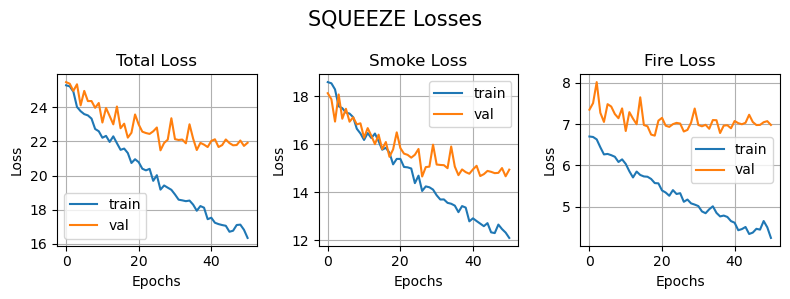

In [20]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()